# OpenVINO™ Explainable AI Toolkit (2/3): Deep Dive

<div class="alert alert-block alert-danger"> <b>Important note:</b> This notebook requires python >= 3.10. Please make sure that your environment fulfill to this requirement before running it </div>

This is the **second notebook** in series of exploring [OpenVINO™ Explainable AI (XAI)](https://github.com/openvinotoolkit/openvino_xai/):

1. [OpenVINO™ Explainable AI Toolkit (1/3): Basic](../explainable-ai-1-basic/README.md)
2. [**OpenVINO™ Explainable AI Toolkit (2/3): Deep Dive**](../explainable-ai-2-deep-dive/README.md)
3. [OpenVINO™ Explainable AI Toolkit (3/3): Saliency map interpretation](../explainable-ai-3-map-interpretation/README.md)

[OpenVINO™ Explainable AI (XAI)](https://github.com/openvinotoolkit/openvino_xai/) provides a suite of XAI algorithms for visual explanation of
[OpenVINO™](https://github.com/openvinotoolkit/openvino) Intermediate Representation (IR) models.

Using **OpenVINO XAI**, you can generate **saliency maps** that highlight regions of interest in input images from the model's perspective. This helps users understand why complex AI models produce specific responses.

This notebook shows an example of how to use OpenVINO XAI, exploring its methods and functionality.

It displays a heatmap indicating areas of interest where a neural network (for classification or detection) focuses before making a decision.

Let's imagine the case that our OpenVINO IR model is up and running on a inference pipeline. While watching the outputs, we may want to analyze the model's behavior for debugging or understanding purposes.

By using the OpenVINO XAI `Explainer`, we can visualize why the model gives such responses, meaning on which areas it focused before predicting a particular label.

<img referrerpolicy="no-referrer-when-downgrade" src="https://static.scarf.sh/a.png?x-pxid=5b5a4db0-7875-4bfb-bdbd-01698b5b1a77&file=notebooks/explainable-ai-2-deep-dive/explainable-ai-2-deep-dive.ipynb" />


#### Table of contents:

- [Prerequisites](#Prerequisites)
    - [Install requirements](#Install-requirements)
    - [Imports](#Imports)
    - [Download IR model](#Download-IR-model)
    - [Load the Image](#Load-the-Image)
    - [Preprocess image for MobileNet](#Preprocess-image-for-MobileNet)
- [Basic usage: `Explainer` in `AUTO` mode](#Basic-usage:-Explainer-in-AUTO-mode)
    - [Create `Explainer` object](#Create-Explainer-object)
    - [Generate `explanation`](#Generate-explanation)
    - [Visualize saliency maps](#Visualize-saliency-maps)
    - [Save saliency maps](#Save-saliency-maps)
    - [Generate saliency maps for all classes](#Generate-saliency-maps-for-all-classes)
- [Pre- and post-process functions](#Pre--and-post-process-functions)
- [Visualization Parameters](#Visualization-Parameters)
- [`Explainer` in `WHITEBOX` mode](#Explainer-in-WHITEBOX-mode)
    - [ReciproCAM XAI method](#ReciproCAM-XAI-method)
    - [Insert XAI branch](#Insert-XAI-branch)
    - [Insertion-related parameters](#Insertion-related-parameters)
- [`Explainer` in `BLACKBOX` mode](#Explainer-in-BLACKBOX-mode)
- [Advanced](#Advanced)
    - [Import ImageNet label names and add them to saliency maps](#Import-ImageNet-label-names-and-add-them-to-saliency-maps)
    - [Activation map XAI method](#Activation-map-XAI-method)


### Installation Instructions

This is a self-contained example that relies solely on its own code.

We recommend  running the notebook in a virtual environment. You only need a Jupyter server to start.
For details, please refer to [Installation Guide](https://github.com/openvinotoolkit/openvino_notebooks/blob/latest/README.md#-installation-guide).

## Prerequisites
[back to top ⬆️](#Table-of-contents:)



### Install requirements
[back to top ⬆️](#Table-of-contents:)


In [1]:
%%capture

import platform

# Install openvino package
%pip install -q "openvino>=2024.2.0" opencv-python tqdm scipy

%pip install -q --no-deps "openvino-xai>=1.1.0"
%pip install -q -U "numpy==1.*"
%pip install -q scipy

if platform.system() != "Windows":
    %pip install -q "matplotlib>=3.4"
else:
    %pip install -q "matplotlib>=3.4,<3.7"

### Imports
[back to top ⬆️](#Table-of-contents:)

In [2]:
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np

import openvino.runtime as ov
from openvino.runtime.utils.data_helpers.wrappers import OVDict
import openvino_xai as xai
from openvino_xai.explainer import ExplainMode
from openvino_xai.explainer.explanation import Explanation

# Fetch `notebook_utils` module
import requests

r = requests.get(
    url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py",
)

open("notebook_utils.py", "w").write(r.text)

from notebook_utils import download_file

### Download IR model
[back to top ⬆️](#Table-of-contents:)


In this notebook for demonstration purposes we'll use an already converted to IR model from OpenVINO storage. 

In [ ]:
base_artifacts_dir = Path("./artifacts").expanduser()

model_name = "v3-small_224_1.0_float"
model_xml_name = f"{model_name}.xml"
model_bin_name = f"{model_name}.bin"

model_xml_path = base_artifacts_dir / model_xml_name

base_url = "https://storage.openvinotoolkit.org/repositories/openvino_notebooks/models/mobelinet-v3-tf/FP32/"

if not model_xml_path.exists():
    download_file(base_url + model_xml_name, model_xml_name, base_artifacts_dir)
    download_file(base_url + model_bin_name, model_bin_name, base_artifacts_dir)
else:
    print(f"{model_name} already downloaded to {base_artifacts_dir}")

In [4]:
# Create ov.Model
model = ov.Core().read_model(model_xml_path)

### Load the Image
[back to top ⬆️](#Table-of-contents:)

'data/coco.jpg' already exists.


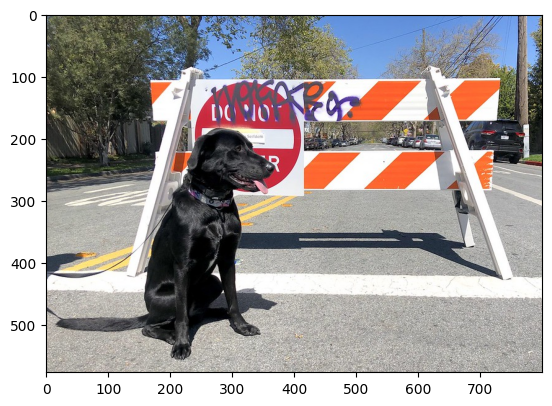

In [5]:
# Download the image from the openvino_notebooks storage
image_filename = download_file(
    "https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/image/coco.jpg",
    directory="data",
)

# The MobileNet model expects images in RGB format.
image = cv2.cvtColor(cv2.imread(filename=str(image_filename)), code=cv2.COLOR_BGR2RGB)
plt.imshow(image)

### Preprocess image for MobileNet
[back to top ⬆️](#Table-of-contents:)

In [6]:
# Resize to MobileNetV3 input image shape.
preprocessed_image = cv2.resize(src=image, dsize=(224, 224))
# Add batch dimension
preprocessed_image = np.expand_dims(preprocessed_image, 0)

## Basic usage: `Explainer` in `AUTO` mode
[back to top ⬆️](#Table-of-contents:)

The easiest way to generate saliency maps is to use `Explainer` in `ExplainMode.AUTO` mode (`AUTO` mode is used by default).

Under the hood of `AUTO` mode, `Explainer` will first try to run the `WHITEBOX` mode. If `WHITEBOX` fails, it will then run the `BLACKBOX` mode as a fallback option.
See more details about [WHITEBOX](#Explainer-in-WHITEBOX-mode) and [BLACKBOX](#Explainer-in-BLACKBOX-mode) modes below.

Generating saliency maps involves model inference. The explainer will perform model inference, but to do so, it requires `preprocess_fn` and `postprocess_fn`.
We can avoid passing `preprocess_fn` by preprocessing (e.g., resizing and adding a batch dimension as shown above) the input data beforehand - by default, `preprocess_fn` is the identity function.
We expect that current example will successfully use `WHITEBOX` mode under the hood, therefore we don't pass `postprocess_fn` (`postprocess_fn` is not required for `WHITEBOX` mode, only for `BLACKBOX`).

To learn more about pre- and post-process functions, refer to the [pre- and post-process functions](#Pre--and-post-process-functions) section.

### Create `Explainer` object
[back to top ⬆️](#Table-of-contents:)

In [ ]:
explainer = xai.Explainer(
    model=model,
    task=xai.Task.CLASSIFICATION,
)

INFO:openvino_xai:Assigning preprocess_fn to identity function assumes that input images were already preprocessed by user before passing it to the model. Please define preprocessing function OR preprocess images beforehand.
INFO:openvino_xai:Target insertion layer is not provided - trying to find it in auto mode.
INFO:openvino_xai:Using ReciproCAM method (for CNNs).
INFO:openvino_xai:Explaining the model in white-box mode.


### Generate `explanation`
[back to top ⬆️](#Table-of-contents:)

The predicted class for this model-image pair is `flat-coated_retriever` with class index `206`. So here and further we will check saliency maps for this index.

In [8]:
# You can choose class(es) to generate saliency maps for.
# In this notebook we will check maps for predicted class with index 206 - "flat-coated retriever"
retriever_class_index = 206

In [9]:
explanation = explainer(
    preprocessed_image,
    targets=retriever_class_index,  # can be a single target or a container of targets
    overlay=True,  # saliency map overlay over the original image, False by default, set to True for better visual inspection
)

### Visualize saliency maps
[back to top ⬆️](#Table-of-contents:)

Saliency maps were generated for the following classes: [206]
Saliency map size: (224, 224, 3)


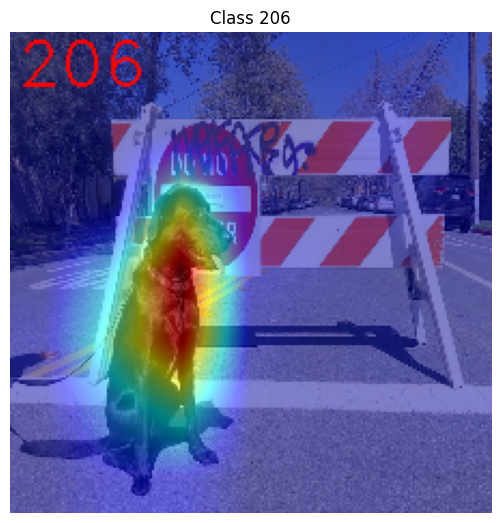

In [10]:
explanation: Explanation
# explanation.saliency_map: Dict[int: np.ndarray]  # where key - class id, value - processed saliency map (e.g. 354 x 500 x 3 shape)

# Check saved saliency maps
print(f"Saliency maps were generated for the following classes: {explanation.targets}")
print(f"Saliency map size: {explanation.shape}")

# Visualize generated saliency maps for each target class (.plot() supports plotting multiple saliency maps)
explanation.plot()

### Save saliency maps
[back to top ⬆️](#Table-of-contents:)

In [11]:
# Save saliency map
explanation.save(base_artifacts_dir, "explain_auto_")

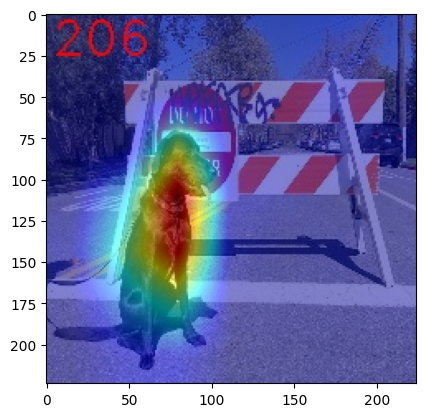

In [12]:
# Plot saved saliency map
image_sal_map = cv2.imread(f"{base_artifacts_dir}/explain_auto_{retriever_class_index}.jpg")
image_sal_map = cv2.cvtColor(image_sal_map, cv2.COLOR_BGR2RGB)
plt.imshow(image_sal_map)

### Generate saliency maps for all classes
[back to top ⬆️](#Table-of-contents:)

To obtain saliency maps for all classes, set `targets` to `None` or `-1`.

In [13]:
explanation = explainer(preprocessed_image, targets=-1)

# Check saved saliency maps
print(f"Saliency maps were generated for the following classes: {explanation.targets[:5]} ... {explanation.targets[-5:]}")
print(f"Saliency map size: {explanation.shape}")

Saliency maps were generated for the following classes: [0, 1, 2, 3, 4] ... [996, 997, 998, 999, 1000]
Saliency map size: (224, 224, 3)


## Pre- and post-process functions
[back to top ⬆️](#Table-of-contents:)

The explainer can apply pre-processing internally during model inference, allowing you to provide a raw image as input to the explainer.

To enable this, define `preprocess_fn` and provide it to the explainer constructor. By default, `preprocess_fn` is an identity function that passes the input without any changes, assuming it is preprocessed beforehand.

In `AUTO` mode, the explainer tries to run the `WHITEBOX` mode first. If it fails, the corresponding exception will be raised, and the `BLACKBOX` mode will be enabled as a fallback.

The `BLACKBOX` mode requires access to the output `logits` (activated or not). Therefore, in such cases, `postprocess_fn` is required, which accepts the raw IR model output and returns `logits` (see below for a reference).


In [14]:
def preprocess_fn(x: np.ndarray) -> np.ndarray:
    # Implementing pre-processing based on model's pipeline
    x = cv2.resize(src=x, dsize=(224, 224))

    # Add batch dimension
    x = np.expand_dims(x, 0)
    return x


def postprocess_fn(x: OVDict):
    # Implementing post-processing function based on model's pipeline
    # Return "logits" model output
    return x[0]

In [15]:
# Create explainer object
explainer = xai.Explainer(
    model=model,
    task=xai.Task.CLASSIFICATION,
    preprocess_fn=preprocess_fn,
    postprocess_fn=postprocess_fn,
)

explanation = explainer(image, targets=retriever_class_index)

INFO:openvino_xai:Target insertion layer is not provided - trying to find it in auto mode.
INFO:openvino_xai:Using ReciproCAM method (for CNNs).
INFO:openvino_xai:Explaining the model in white-box mode.


## Visualization Parameters
[back to top ⬆️](#Table-of-contents:)

- resize (True by default): If True, resize saliency map to the input image size.
- colormap (True by default): If True, apply colormap to the grayscale saliency map.
- overlay (False by default): If True, generate overlay of the saliency map over the input image.
- original_input_image (None by default): Provide the original, unprocessed image to apply the overlay. This ensures the overlay is not applied to a preprocessed image, which may be resized or normalized and lose readability.
- overlay_weight (0.5 by default): Weight of the saliency map when overlaying the input data with the saliency map.

INFO:openvino_xai:Assigning preprocess_fn to identity function assumes that input images were already preprocessed by user before passing it to the model. Please define preprocessing function OR preprocess images beforehand.
INFO:openvino_xai:Target insertion layer is not provided - trying to find it in auto mode.
INFO:openvino_xai:Using ReciproCAM method (for CNNs).
INFO:openvino_xai:Explaining the model in white-box mode.


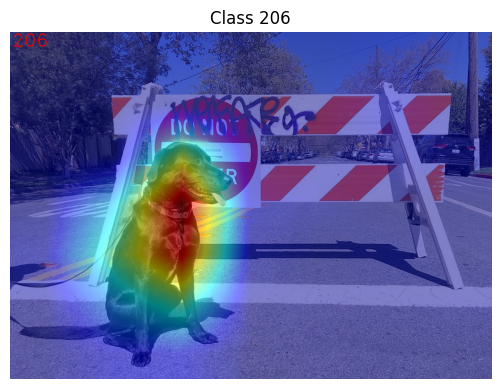

In [16]:
# Create explainer object
explainer = xai.Explainer(model=model, task=xai.Task.CLASSIFICATION)

# Generate overlayed saliency_map
explanation = explainer(
    preprocessed_image,
    targets=[retriever_class_index],  # target can be a single label index, label name or a list of indices/names
    overlay=True,  # False by default
    original_input_image=image,  # to apply overlay on the original image instead of preprocessed one that was used for the explainer
)

explanation.plot()

# Save saliency map
explanation.save(base_artifacts_dir, "overlay_")

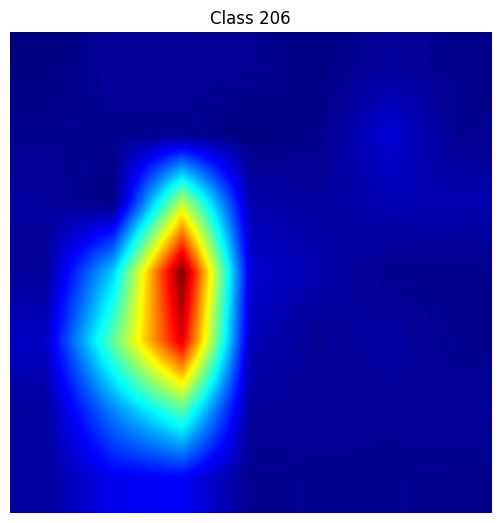

In [17]:
# Generate saliency map without overlay over original image
explanation = explainer(
    preprocessed_image,
    targets=[retriever_class_index],  # target can be a single label index, label name or a list of indices/names
    overlay=False,  # False by default
)

explanation.plot()

# Save saliency map
explanation.save(base_artifacts_dir, "colormap_")

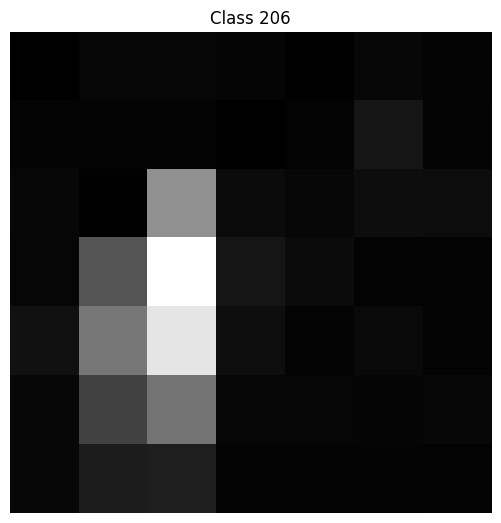

In [18]:
# Return low-resolution (raw) gray-scale saliency map
explanation = explainer(
    preprocessed_image,
    targets=[retriever_class_index],  # target can be a single label index, label name or a list of indices/names
    resize=False,  # True by default
    colormap=False,  # True by default
)

explanation.plot()

# Save saliency map
explanation.save(base_artifacts_dir, "grayscale_")

## `Explainer` in `WHITEBOX` mode
[back to top ⬆️](#Table-of-contents:)


### `ReciproCAM` XAI method
[back to top ⬆️](#Table-of-contents:)


`Explainer` in `WHITEBOX` mode treats the model as a white box and performs its inner modifications. `Explainer` inserts extra XAI nodes after the backbone to estimate which activations are important for model prediction.

If a method is not specified, the XAI branch will be generated using the [ReciproCAM](https://arxiv.org/abs/2209.14074) method.

By default, the insertion of the XAI branch will be done automatically by searching for the correct node - `target_layer` (`target_layer` can be specified manually).

It works quickly and precisely, requiring only one model inference.

In [19]:
# Create explainer object
explainer = xai.Explainer(
    model=model,
    task=xai.Task.CLASSIFICATION,
    preprocess_fn=preprocess_fn,
    explain_mode=ExplainMode.WHITEBOX,  # defaults to ExplainMode.AUTO
    explain_method=xai.Method.RECIPROCAM,  # ReciproCAM is the default white-box method for CNNs
)

INFO:openvino_xai:Target insertion layer is not provided - trying to find it in auto mode.
INFO:openvino_xai:Using ReciproCAM method (for CNNs).
INFO:openvino_xai:Explaining the model in white-box mode.


### Insert XAI branch
[back to top ⬆️](#Table-of-contents:)

It's possible to update the model with an XAI branch using the `insert_xai` functional API.

`insert_xai` will return an OpenVINO model with the XAI branch inserted and an additional `saliency_map` output.

This helps to avoid OpenVINO XAI dependency in the inference environment.

**Note**: XAI branch introduce an additional computational overhead (usually less than a single model forward pass).

In [20]:
# insert XAI branch
model_xai: ov.Model
model_xai = xai.insert_xai(
    model,
    task=xai.Task.CLASSIFICATION,
    explain_method=xai.Method.RECIPROCAM,
    target_layer="MobilenetV3/Conv_1/Conv2D",  # optional, by default insert_xai will try to find target_layer automatically
    embed_scaling=True,
)

INFO:openvino_xai:Target insertion layer MobilenetV3/Conv_1/Conv2D is provided.
INFO:openvino_xai:Using ReciproCAM method (for CNNs).
INFO:openvino_xai:Insertion of the XAI branch into the model was successful.


**Note**: `insert_xai` supports both OpenVINO IR and PyTorch models. See documentation for more details.

### Insertion-related parameters
[back to top ⬆️](#Table-of-contents:)


If automatic search for correct node fails, you can set up a correct node manually with `target_layer` argument. 
For classification, it's the last backbone node with shape [1, num_channels, feature_map_height, feature_map_width]. 
For example, for the used MobileNetV3 it will be `MobilenetV3/Conv_1/Conv2D` layer with [1, 576, 7, 7] output shape.

To find the right `target_layer` for your model, check the name of the last convolutional node in the backbone using `.XML` file (optionally, use some graph visualization tool, such as Netron).

`embed_scaling` **default True** (for speed purposes), this parameter ensures that saliency map scaling is embedded into the graph, which results in being able to visualize saliency maps right away without further postprocessing.

In [21]:
# Create explainer object
explainer = xai.Explainer(
    model=model,
    task=xai.Task.CLASSIFICATION,
    preprocess_fn=preprocess_fn,
    explain_mode=ExplainMode.AUTO,
    explain_method=xai.Method.RECIPROCAM,
    # target_layer="last_conv_node_name",  # target_layer - node after which XAI branch will be inserted
    target_layer="MobilenetV3/Conv_1/Conv2D",
    embed_scaling=True,  # True by default.  If set to True, saliency map scale (0 ~ 255) operation is embedded in the model
)

INFO:openvino_xai:Target insertion layer MobilenetV3/Conv_1/Conv2D is provided.
INFO:openvino_xai:Using ReciproCAM method (for CNNs).
INFO:openvino_xai:Explaining the model in white-box mode.


## `Explainer` in `BLACKBOX` mode
[back to top ⬆️](#Table-of-contents:)

`Explainer` in `BLACKBOX` mode treats the model as a black box without altering its internal structure. Therefore, this method will work on any model that can be inferred and return class scores as output.

While it is convenient to treat every model as a black box for explanation purposes, black-box method may require a significant number of inferences (AISE requires 120-500 model inferences).

Given that the quality of the saliency maps usually correlates with the number of available inferences, we propose the following presets for the black-box methods: `Preset.SPEED`, `Preset.BALANCE`, `Preset.QUALITY` (`Preset.BALANCE` is used by default).

### AISE (Adaptive Input Sampling for Explanation of Black-box Models)

AISE is used as a default black-box method. 
AISE formulates saliency map generation as a kernel density estimation (KDE) problem, and adaptively sample input masks using a derivative-free optimizer to maximize mask saliency score.

In [22]:
# Create explainer object
explainer = xai.Explainer(
    model=model,
    task=xai.Task.CLASSIFICATION,
    preprocess_fn=preprocess_fn,
    postprocess_fn=postprocess_fn,
    explain_mode=ExplainMode.BLACKBOX,  # defaults to AUTO
)

# Generate explanation
explanation = explainer(
    image,
    targets=retriever_class_index,
    overlay=True,
)

INFO:openvino_xai:Explaining the model in black-box mode.


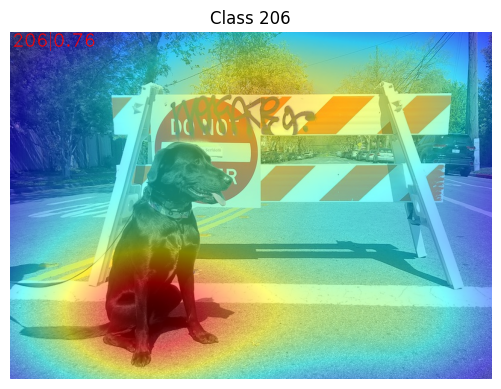

In [23]:
# Plot saliency map
explanation.plot()

# Save saliency map
explanation.save(base_artifacts_dir, "blackbox_aise_")

### RISE (Randomized Input Sampling for Explanation of Black-box Models)

[RISE](https://arxiv.org/pdf/1806.07421) probes a model by sub-sampling the input image via random masks and records its response to each of them. 
RISE creates random masks from down-scaled space (e.g. 7×7 grid) and adds random translation shifts for the pixel-level explanation with further up-sampling. 
Weighted sum of all sampled masks used to generate the fine-grained saliency map.

In [ ]:
# Create explainer object
explainer = xai.Explainer(
    model=model,
    task=xai.Task.CLASSIFICATION,
    preprocess_fn=preprocess_fn,
    postprocess_fn=postprocess_fn,
    explain_mode=ExplainMode.BLACKBOX,  # defaults to AUTO
    explain_method=xai.Method.RISE,  # xai.Method.AISE is used by default
)

# Generate explanation
explanation = explainer(
    image,
    targets=retriever_class_index,
    overlay=True,
)

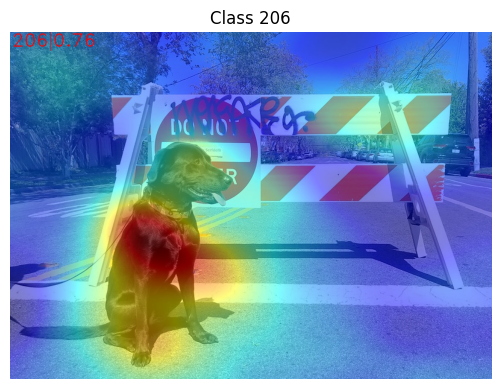

In [25]:
# Plot saliency map
explanation.plot()

# Save saliency map
explanation.save(base_artifacts_dir, "blackbox_rise_")

## Advanced
[back to top ⬆️](#Table-of-contents:)

### Import ImageNet label names and add them to saliency maps
[back to top ⬆️](#Table-of-contents:)

If `label_names` are not provided to the explainer call, the saved saliency map will have the predicted class index, not the label name. For example, `206.jpg` instead of `retriever.jpg`.

To conveniently view label names in saliency maps, we provide ImageNet label names information to the explanation call.

In [26]:
imagenet_filename = download_file(
    "https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/datasets/imagenet/imagenet_2012.txt",
    directory="data",
)

imagenet_classes = imagenet_filename.read_text().splitlines()

'data/imagenet_2012.txt' already exists.


In [27]:
imagenet_labels = []
for label in imagenet_classes:
    class_label = " ".join(label.split(" ")[1:])
    first_class_label = class_label.split(",")[0].replace(" ", "_")
    imagenet_labels.append(first_class_label)

print(" ".join(imagenet_labels[:10]))

tench goldfish great_white_shark tiger_shark hammerhead electric_ray stingray cock hen ostrich


In [28]:
# The model description states that for this model, class 0 is a background.
# Therefore, a background must be added at the beginning of imagenet_classes.
imagenet_labels = ["background"] + imagenet_labels

In [29]:
# Create explainer object
explainer = xai.Explainer(
    model=model,
    task=xai.Task.CLASSIFICATION,
    preprocess_fn=preprocess_fn,
    explain_mode=ExplainMode.WHITEBOX,
)

# Adding ImageNet label names.
explanation = explainer(
    image,
    # Return saliency maps for 2 named labels, possible if label_names is provided
    targets=["flat-coated_retriever", "microwave"],  # slso label indices [206, 652] are possible as target
    label_names=imagenet_labels,
)

INFO:openvino_xai:Target insertion layer is not provided - trying to find it in auto mode.
INFO:openvino_xai:Using ReciproCAM method (for CNNs).
INFO:openvino_xai:Explaining the model in white-box mode.


In [30]:
# Save saliency map
explanation.save(base_artifacts_dir, "label_names_")

Below in `base_artifacts_dir / "label_names"` you can see saved saliency maps with label name on it:

In [31]:
# See saliency mas saved in `output` with predicted label in image name
for file_name in base_artifacts_dir.glob("label_names_*"):
    print(file_name)

artifacts/label_names_microwave.jpg
artifacts/label_names_flat-coated_retriever.jpg


### Activation map XAI method
[back to top ⬆️](#Table-of-contents:)

The Activation Map method shows a general attention map without respect to specific classes. It can be useful for understanding which areas the model identifies as important.

If the explanation method is set to `Method.ACTIVATIONMAP`, instead of saliency maps for each class, the activation map is returned as `explanation.saliency_map["per_image_map"]`.

INFO:openvino_xai:Target insertion layer is not provided - trying to find it in auto mode.
INFO:openvino_xai:Using ActivationMap method (for CNNs).
INFO:openvino_xai:Explaining the model in white-box mode.


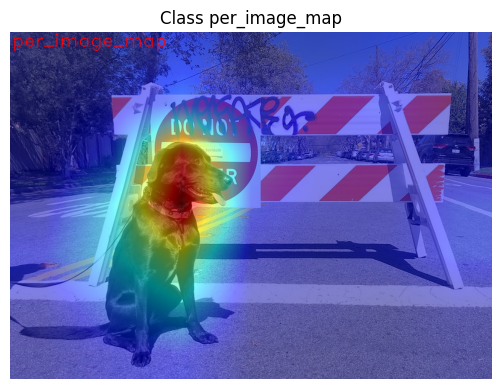

In [32]:
# Create explainer object
explainer = xai.Explainer(
    model=model,
    task=xai.Task.CLASSIFICATION,
    preprocess_fn=preprocess_fn,
    explain_mode=ExplainMode.WHITEBOX,
    explain_method=xai.Method.ACTIVATIONMAP,
)

explanation = explainer(image, overlay=True)
explanation.plot()